In [0]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
 !wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-05-25 00:11:05--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.53MB/s    in 43s     

2020-05-25 00:11:49 (7.11 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [0]:
# extract the zip file
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/rockpaperscissors'

menggunakan library **split-folders** untuk membagi dataset menjadi data train dan validation

In [4]:
!pip install split-folders

import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio(base_dir+"/rps-cv-images", output=base_dir+"/split-result", seed=1337, ratio=(.8, .2)) 

Copying files: 2188 files [00:00, 5174.05 files/s]


In [5]:
os.listdir('/tmp/rockpaperscissors/split-result')

['train', 'val']

In [0]:
train_dir = os.path.join(base_dir, 'split-result', 'train')
validation_dir = os.path.join(base_dir, 'split-result', 'val')

In [7]:
os.listdir(train_dir)

['rock', 'scissors', 'paper']

In [8]:
os.listdir(validation_dir)

['rock', 'scissors', 'paper']

membuat sub direktori untuk setiap kelas pada direktori training dan direktori validasi.

In [0]:
# membuat direktori gunting pada direktori data training
train_scissors_dir = os.path.join(train_dir, 'scissors')
# membuat direktori batu pada direktori data training
train_rock_dir = os.path.join(train_dir, 'rock')
# membuat direktori kertas pada direktori data training
train_paper_dir = os.path.join(train_dir, 'paper')
 
# membuat direktori gunting pada direktori data validasi
validation_scissors_dir = os.path.join(validation_dir, 'scissors')
# membuat direktori batu pada direktori data validasi
validation_rock_dir = os.path.join(validation_dir, 'rock')
# membuat direktori kertas pada direktori data validasi
validation_paper_dir = os.path.join(validation_dir, 'paper')

Buat objek **ImageDataGenerator** untuk data training dan data testing. Image data generator adalah sebuah fungsi yang sangat berguna untuk mempersiapkan data training dan data testing yang akan diberikan ke model. Beberapa kemudahan yang disediakan Image data generator adalah, preprocessing data, pelabelan sampel otomatis, dan augmentasi gambar.

Kode di bawah menunjukkan proses augmentasi gambar pada setiap sampel di dataset. Augmentasi gambar adalah teknik untuk menciptakan data-data baru dari data yang telah ada.

In [0]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode='nearest',
                    width_shift_range=0.2,
                    height_shift_range=0.2)
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode='nearest',
                    width_shift_range=0.2,
                    height_shift_range=0.2)

Gunakan objek image data generator sebelumnya untuk mempersiapkan data train yang akan dipelajari oleh model.

In [11]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(100, 150),  
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, 
        target_size=(100, 150), 
        batch_size=batch_size, 
        class_mode='categorical')

Found 1749 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


Setelah data telah siap, bangun arsitektur sebuah CNN. Sebuah CNN pada keras mirip dengan MLP untuk klasifikasi fashion MNIST. Perbedaannya hanya pada terdapatnya 2 lapis layer konvolusi dan max pooling. Fungsi dari layer konvolusi adalah untuk mengekstraksi atribut pada gambar. Sedangkan layer max pooling berguna untuk mereduksi resolusi gambar sehingga proses pelatihan MLP lebih cepat.

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')
])

#model.summary()

Setelah membuat arsitektur dari CNN, panggil fungsi compile pada objek model, dan tentukan loss function serta optimizer.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

Setelah menentukan loss function dan optimizer pada CNN, kita dapat melatih model kita menggunakan metode fit. Dengan menggunakan image data generator, kita tidak perlu memasukkan parameter gambar dan labelnya. Image data generator secara otomatis melabeli sebuah gambar sesuai dengan direktori di mana ia disimpan. 

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n // batch_size,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=20,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=validation_generator.n // batch_size,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=1,
      callbacks = [callback])

Epoch 1/20
54/54 [==============================] - 11s 198ms/step - loss: 1.0010 - accuracy: 0.4980 - val_loss: 0.6658 - val_accuracy: 0.7139
Epoch 2/20
54/54 [==============================] - 11s 196ms/step - loss: 0.5021 - accuracy: 0.7880 - val_loss: 0.4641 - val_accuracy: 0.8269
Epoch 3/20
54/54 [==============================] - 10s 194ms/step - loss: 0.4096 - accuracy: 0.8509 - val_loss: 0.3963 - val_accuracy: 0.8678
Epoch 4/20
54/54 [==============================] - 10s 194ms/step - loss: 0.3380 - accuracy: 0.8794 - val_loss: 0.3620 - val_accuracy: 0.8822
Epoch 5/20
54/54 [==============================] - 10s 194ms/step - loss: 0.3323 - accuracy: 0.8725 - val_loss: 0.2213 - val_accuracy: 0.9255
Epoch 6/20
54/54 [==============================] - 10s 194ms/step - loss: 0.2418 - accuracy: 0.9150 - val_loss: 0.1889 - val_accuracy: 0.9375
Epoch 7/20
54/54 [==============================] - 10s 194ms/step - loss: 0.2063 - accuracy: 0.9289 - val_loss: 0.1700 - val_accuracy: 0.9375

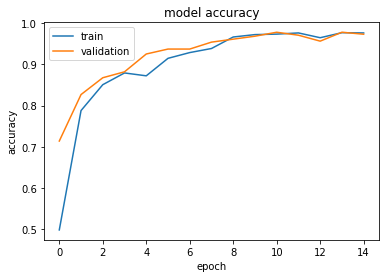

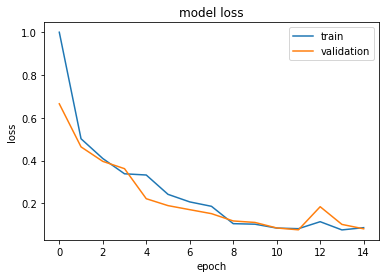

In [15]:
# model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Terakhir, lihat hasil dari model yang telah kita buat. 

Saving Rock-paper-scissors_(paper).png to Rock-paper-scissors_(paper).png
Rock-paper-scissors_(paper).png
paper


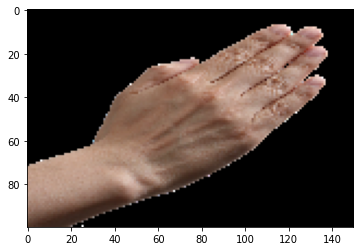

Saving Rock-paper-scissors_(scissors).png to Rock-paper-scissors_(scissors).png
Rock-paper-scissors_(scissors).png
scissors


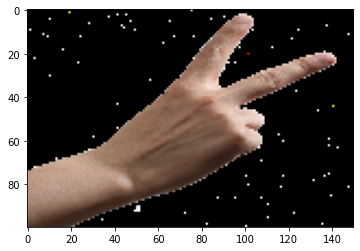

In [18]:
import numpy as np
from google.colab import files
from keras.preprocessing import image 
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(100,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img) 
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=batch_size)
  result = np.argmax(classes)
  
  print(fn)

  if result==0:
    print('paper')
  elif result==1:
   print('rock')
  elif result==2:
    print('scissors')